<a href="https://colab.research.google.com/github/wmezadev/CSE-450-TEAM-4/blob/main/module-5/Signs_module_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import PIL
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
import pathlib
import urllib.request
import zipfile
import os
import shutil

# delete the training folder if it was there from a previous run
if not os.path.exists('training'):
  # URLs for the datasets
  dataset_url_1 = "https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/roadsigns/training1.zip"
  dataset_url_2 = "https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/roadsigns/training2.zip"

  # Download the ZIP files
  zip_file_1, _ = urllib.request.urlretrieve(dataset_url_1)
  zip_file_2, _ = urllib.request.urlretrieve(dataset_url_2)

  # Extract the contents of training1.zip
  with zipfile.ZipFile(zip_file_1, 'r') as zip_ref:
      zip_ref.extractall()

  # Extract the contents of training2.zip
  with zipfile.ZipFile(zip_file_2, 'r') as zip_ref:
      zip_ref.extractall()

  # Merge training1 and training2 folders
  training1 = os.listdir('training1')
  training2 = os.listdir('training2')

  for item in training1:
    source_item = os.path.join('training1', item)

    destination_item = os.path.join('training', item)

    shutil.copytree(source_item, destination_item)

  for item in training2:
    source_item = os.path.join('training2', item)

    destination_item = os.path.join('training', item)

    if os.path.isfile(source_item):
        shutil.copy2(source_item, destination_item)
    elif os.path.isdir(source_item):
        shutil.copytree(source_item, destination_item)

  # clean up
  os.remove(zip_file_1)
  os.remove(zip_file_2)
  shutil.rmtree('training1')
  shutil.rmtree('training2')

# Path to the merged dataset directory
data_dir = pathlib.Path("training")

# our learning rates/sizes
batch_size = 32
img_height = 100
img_width = 100

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)



39209


Creates the train, and validation sets

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 39209 files belonging to 43 classes.
Using 31368 files for training.
Found 39209 files belonging to 43 classes.
Using 7841 files for validation.


Print some images so we have an idea of what we are working with

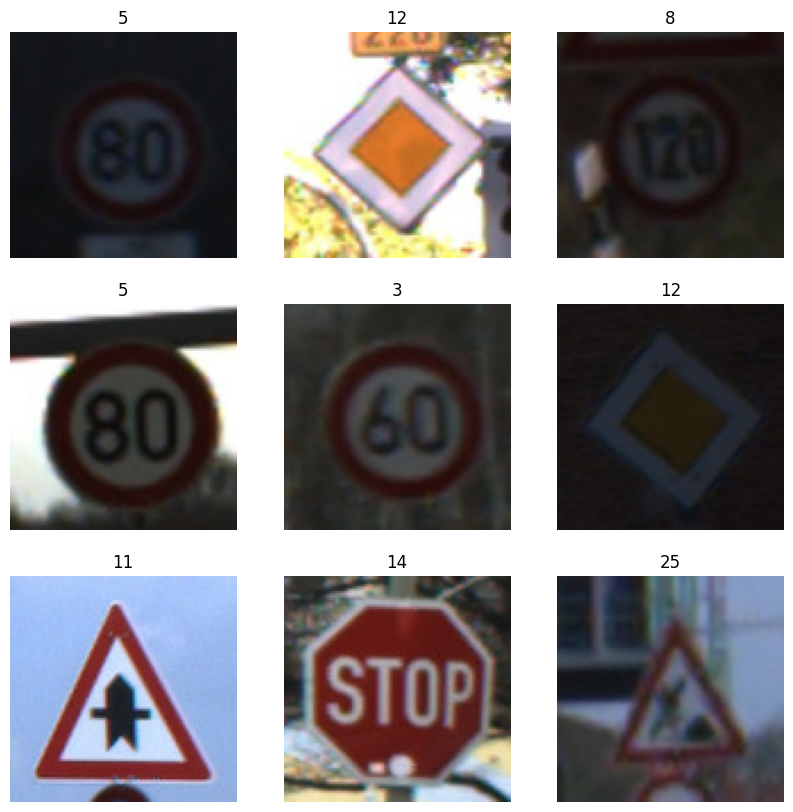

In [ ]:
class_names = []

for name in train_ds.class_names:
  if name[-1] == '0':
    class_names.append(0)
  else:
    class_names.append(int(name.strip('0')))

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

This part is just for performance improvement

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Actual Model

In [ ]:
num_classes = len(class_names)

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
    input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

model.compile(optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/15
981/981 [==============================] - 33s 14ms/step - loss: 1.3979 - accuracy: 0.5911 - val_loss: 0.4752 - val_accuracy: 0.8457
Epoch 2/15
981/981 [==============================] - 11s 11ms/step - loss: 0.4311 - accuracy: 0.8645 - val_loss: 0.2297 - val_accuracy: 0.9338
Epoch 3/15
981/981 [==============================] - 11s 11ms/step - loss: 0.2834 - accuracy: 0.9107 - val_loss: 0.1802 - val_accuracy: 0.9430
Epoch 4/15
981/981 [==============================] - 12s 12ms/step - loss: 0.2117 - accuracy: 0.9325 - val_loss: 0.1257 - val_accuracy: 0.9597
Epoch 5/15
981/981 [==============================] - 11s 11ms/step - loss: 0.1844 - accuracy: 0.9431 - val_loss: 0.1107 - val_accuracy: 0.9694
Epoch 6/15
981/981 [==============================] - 11s 11ms/step - loss: 0.1590 - accuracy: 0.9501 - val_loss: 0.0963 - val_accuracy: 0.9721
Epoch 7/15
981/981 [==============================] - 11s 11ms/step - loss: 0.1379 - accuracy: 0.9558 - val_loss: 0.0893 - val_accuracy:

Visual Results

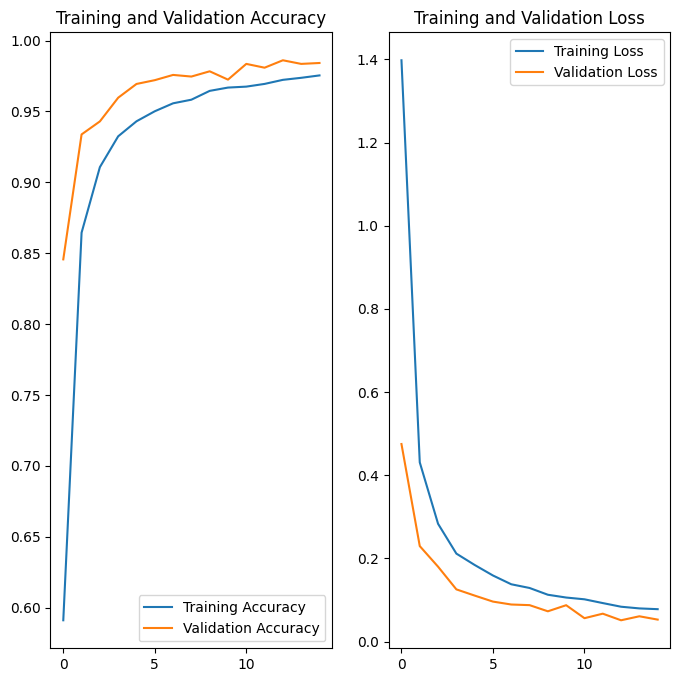

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Testing the model
Once you have built and trained your model, the next step is to run the test images through it and see how well your model does at making predictions for images it has never seen before.

Since loading these images and formatting them for the model can be tricky, you may find the following code useful. This code only uses your model to predict the class label for a given image. You'll still need to compare those predictions to the "ground truth" class labels in `test_classes_partial.csv` to evaluate how well the model does.



```
from tensorflow.keras.preprocessing import image_dataset_from_directory
test_dir = '/content/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['test_partial'],
        target_size=image_size,
        class_mode='sparse',
        shuffle=False)
probabilities = model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]
```



In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

if not os.path.exists('test'):
  test_url = 'https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/roadsigns/test.zip'

  # Download the ZIP file
  test_files, _ = urllib.request.urlretrieve(test_url)

  # Extract the contents of test_partial.zip
  with zipfile.ZipFile(test_files, 'r') as zip_ref:
      zip_ref.extractall()

test_dir = os.listdir('test')
test_dir.sort()
y_pred=[]

for index in range(len(test_dir)):
  dir = os.path.join('test', test_dir[index])
  # print(dir)

  img = tf.keras.utils.load_img(
      dir, target_size=(img_height, img_width)
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array, verbose=0)
  score = tf.nn.softmax(predictions[0])

  y_pred.append(class_names[np.argmax(score)])
  # print(
  #     "This image most likely belongs to {} with a {:.2f} percent confidence."
  #     .format(class_names[np.argmax(score)], 100 * np.max(score))
  # )

#save results to csv file
import csv
with open('team4-module5-predictions.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['predictions'])
    for pred in y_pred:
        writer.writerow([pred])

##Partial Hold out Dataset
You're given the answers to the first 200 images in the hold out dataset.

Once you have predictions for the partial holdout dataset, you'll need to compare those predictions against the "ground truth" class labels in `test_classes_partial.csv` to evaluate how well the model does.

Make sure to use the insights gained from the partial hold out dataset in your executive summary.

Once you feel confident, you will need to predict for the full test dataset using the following code, and submit your csv file:

```
from tensorflow.keras.preprocessing import image_dataset_from_directory
test_dir = '/content/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['test'],
        target_size=image_size,
        class_mode='sparse',
        shuffle=False)
probabilities = model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]
```

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

if not os.path.exists('test_partial'):
  test_partial_url = 'https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/roadsigns/test_partial.zip' # 83-85%

  # Download the ZIP file
  test_files, _ = urllib.request.urlretrieve(test_partial_url)

  # Extract the contents of test_partial.zip
  with zipfile.ZipFile(test_files, 'r') as zip_ref:
      zip_ref.extractall()

test_partial_dir = os.listdir('test_partial')
test_partial_dir.sort()
y_pred=[]

for index in range(len(test_partial_dir)):
  dir = os.path.join('test', test_partial_dir[index])
  # print(dir)

  img = tf.keras.utils.load_img(
      dir, target_size=(img_height, img_width)
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array, verbose=0)
  score = tf.nn.softmax(predictions[0])

  y_pred.append(class_names[np.argmax(score)])
  # print(
  #     "This image most likely belongs to {} with a {:.2f} percent confidence."
  #     .format(class_names[np.argmax(score)], 100 * np.max(score))
  # )

# Calculate accuracy on partial holdout set
ground_truth = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/roadsigns/test_classes_partial.csv')
y_true = ground_truth['ClassId'].values
accuracy = np.sum(y_pred == y_true) / len(y_true)
print(f'Accuracy on test set: {accuracy}')

Accuracy on test set: 0.8109452736318408
